In [1]:
import odc

import geopandas as gpd
import pandas as pd
import numpy as np

import aup

## Guadalajara hexagon grid

In [2]:
schema = 'hexgrid'
folder = 'hexgrid_8_city_2020'
city = 'Guadalajara'
type_area = 'urban'

query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" = \'{city}\' AND \"type\" = \'{type_area}\'"

hex_gdf = aup.gdf_from_query(query)
hex_gdf = hex_gdf.set_crs("EPSG:4326")
print(hex_gdf.shape)
hex_gdf.head(2)

(1132, 6)


,hex_id_8,geometry,CVEGEO,NOMGEO,city,type
0,88498c9421fffff,"POLYGON ((-103.28663 20.69309, -103.28209 20.6...",14039,Guadalajara,Guadalajara,urban
1,88498c9405fffff,"POLYGON ((-103.30025 20.68392, -103.29571 20.6...",14039,Guadalajara,Guadalajara,urban


## Edges and nodes

In [3]:
G,nodes,edges = aup.graph_from_hippo(hex_gdf, schema='osmnx', 
                    edges_folder='edges_elevation_23_line', nodes_folder='nodes_osmnx_23_point')

<Axes: >

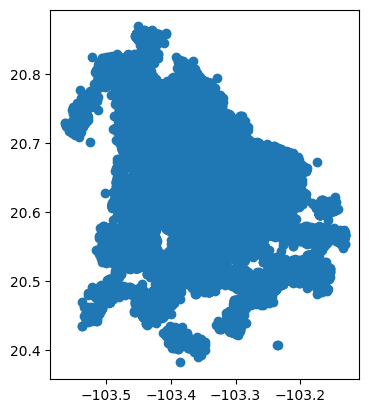

In [4]:
nodes.plot()

In [5]:
edges_var = edges.copy()
edges_var = edges_var.reset_index()
edges_var = edges_var.to_crs("EPSG:32613")
edges_var = edges_var[['u','v','key','osmid','grade_abs','geometry']]

 ## Edges buffer

In [6]:
edges_buffer = edges_var.copy()
edges_buffer['geometry'] = edges_buffer.buffer(30)

In [7]:
edges_buffer.head(2)

,u,v,key,osmid,grade_abs,geometry
0,1774344156,1827050267,0,782694623,0.014,"POLYGON ((675029.493 2274948.17, 675028.02 227..."
1,1774344156,6511605645,0,"[473698618, 693569732]",0.005,"POLYGON ((674909.825 2275036.735, 674907.265 2..."


## Sidewalks

In [8]:
gdf_tmp = hex_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.set_geometry("geometry")
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [9]:
query = f"SELECT * FROM censo_urbano.censo_fm_2020 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
entorno = aup.gdf_from_query(query, geometry_col='geometry')
print(entorno.shape350121)
entorno.head(4)

(261012, 68)


,CVEGEO2,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,CVEVIAL_x,CVESEG,CVEFT_x,NOMVIAL_x,...,ESTACIONBICI,ARBOLES,ALUMPUB,TELPUB,PUESTOSEMI,PUESTOAMBU,BANQUETA,GUARNICION,TAMLOC,VIANOESP
0,1412000013185020,14,120,0001,3185,020,07967,00001,4,Ninguno,...,3,3,3,3,3,3,3,1,11,0
1,1412000013185020,14,120,0001,3185,020,07967,00001,6,Ninguno,...,3,3,1,3,3,3,3,1,11,0
2,1412000011850003,14,120,0001,1850,003,04876,00008,4,Trafalgar,...,3,1,1,3,3,3,1,1,11,0
3,1412000011850006,14,120,0001,1850,006,07991,00001,3,Pasamontes,...,3,1,3,3,3,3,1,1,11,0


### Sidewalks to edges

In [10]:
entorno = entorno.to_crs("EPSG:32613")

In [11]:
entorno_edges = entorno.overlay(edges_buffer, how='intersection')
print(entorno_edges.shape)
entorno_edges.head(2)

(3256374, 73)


,CVEGEO2,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,CVEVIAL_x,CVESEG,CVEFT_x,NOMVIAL_x,...,BANQUETA,GUARNICION,TAMLOC,VIANOESP,u,v,key,osmid,grade_abs,geometry
0,1412000013185020,14,120,0001,3185,020,07967,00001,4,Ninguno,...,3,1,11,0,1926295441,6456324450,0,695014932,0.007,"LINESTRING (666665.557 2294769.363, 666663.342..."
1,1412000013185020,14,120,0001,3185,020,07967,00001,4,Ninguno,...,3,1,11,0,1926295436,6456324448,0,695014932,0.000,"LINESTRING (666670.024 2294784.909, 666663.342..."


In [12]:
entorno_edges['length'] = entorno_edges.length

In [13]:
banqueta_edges = entorno_edges[['u','v','key','BANQUETA','length']].groupby(['u','v','key','BANQUETA']).sum()
banqueta_edges = banqueta_edges.reset_index()
print(banqueta_edges.shape)
banqueta_edges.head(2)

(608685, 5)


,u,v,key,BANQUETA,length
0,28751344,28757777,0,1,526.522615
1,28751344,28757777,0,3,57.822121


In [14]:
edges_var = edges_var.merge(banqueta_edges.loc[banqueta_edges.BANQUETA==1,['u','v','key','length']],
                            on=['u','v','key'], how='left')
edges_var = edges_var.rename(columns={'length':'BANQUETA_1'})
edges_var = edges_var.merge(banqueta_edges.loc[banqueta_edges.BANQUETA==3,['u','v','key','length']],
                            on=['u','v','key'], how='left')
edges_var = edges_var.rename(columns={'length':'BANQUETA_3'})
print(edges_var.shape)
edges_var.head(2)

(414592, 8)


,u,v,key,osmid,grade_abs,geometry,BANQUETA_1,BANQUETA_3
0,1774344156,1827050267,0,782694623,0.014,"LINESTRING (675034.767 2275024.049, 675002.812...",55.710685,373.889793
1,1774344156,6511605645,0,"[473698618, 693569732]",0.005,"LINESTRING (675034.767 2275024.049, 674919.897...",198.590547,509.955665


In [15]:
edges_var['banqueta_pct'] = edges_var['BANQUETA_1'] / (edges_var['BANQUETA_1'] + edges_var['BANQUETA_3'])

<Axes: >

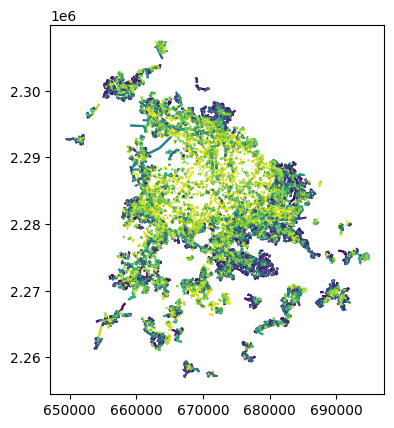

In [16]:
edges_var.plot('banqueta_pct')

## NDVI

In [17]:
schema = 'raster_analysis'
folder = 'ndvi_analysis_hex'
city = 'Guadalajara'
res = 10

query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" = \'{city}\' AND \"res\" = {res}"

ndvi = aup.gdf_from_query(query)
ndvi = ndvi.set_crs("EPSG:4326")
print(ndvi.shape)
ndvi.head(2)

(69464, 11)


,hex_id,geometry,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city
0,8a498c96e667fff,"POLYGON ((-103.35634 20.6763, -103.3557 20.676...",10,0.103965,0.026140,0.105288,0.129802,0.081518,0.048284,-0.001021,Guadalajara
1,8a498c946907fff,"POLYGON ((-103.29383 20.66205, -103.29318 20.6...",10,0.086757,0.018846,0.091987,0.101378,0.075630,0.025749,-0.000612,Guadalajara


### NDVI to edges

In [18]:
ndvi = ndvi.to_crs("EPSG:32613")

In [19]:
ndvi_edges = ndvi.overlay(edges_buffer, how='intersection')
print(ndvi_edges.shape)
ndvi_edges.head(2)

(1177997, 16)


,hex_id,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city,u,v,key,osmid,grade_abs,geometry
0,8a498c96e667fff,10,0.103965,0.02614,0.105288,0.129802,0.081518,0.048284,-0.001021,Guadalajara,1369529324,1369529307,0,33266886,0.011,"POLYGON ((671273.516 2287239.475, 671256.045 2..."
1,8a498c96e667fff,10,0.103965,0.02614,0.105288,0.129802,0.081518,0.048284,-0.001021,Guadalajara,377745106,6465879717,0,33266644,0.000,"POLYGON ((671188.717 2287354.575, 671220.642 2..."


In [20]:
ndvi_edges = ndvi_edges[['u','v','key','ndvi_mean']].groupby(['u','v','key']).mean()

In [21]:
ndvi_edges = ndvi_edges.reset_index()

In [22]:
ndvi_edges.head(2)

,u,v,key,ndvi_mean
0,28751344,28757777,0,0.176572
1,28751344,1610958191,0,0.163187


In [23]:
edges_var = edges_var.merge(ndvi_edges,
                            on=['u','v','key'], how='left')
print(edges_var.shape)
edges_var.head(2)

(414592, 10)


,u,v,key,osmid,grade_abs,geometry,BANQUETA_1,BANQUETA_3,banqueta_pct,ndvi_mean
0,1774344156,1827050267,0,782694623,0.014,"LINESTRING (675034.767 2275024.049, 675002.812...",55.710685,373.889793,0.129680,0.199545
1,1774344156,6511605645,0,"[473698618, 693569732]",0.005,"LINESTRING (675034.767 2275024.049, 674919.897...",198.590547,509.955665,0.280279,0.202863


<Axes: >

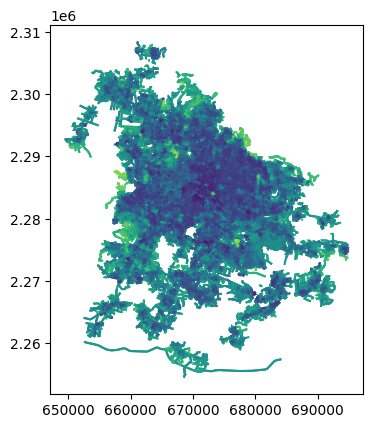

In [24]:
edges_var.plot('ndvi_mean')

In [25]:
# edges_var.to_file('../../../data/processed/vref/edges_physical_variables.geojson')

In [26]:
# nodes.to_file('../../../data/processed/vref/nodes.geojson')

## Population

In [27]:
nodes_id = edges_var.v.unique().tolist()
u = edges_var.u.unique().tolist()
nodes_id.extend(u)
myset = set(nodes_id)
nodes_id = list(myset)
schema = 'censo'
nodes_folder = 'pobcenso_inegi_20_mzaageb_node'
nodes_query = f"SELECT * FROM {schema}.{nodes_folder} WHERE osmid IN {str(tuple(nodes_id))}"
nodes_pop = aup.gdf_from_query(nodes_query, geometry_col="geometry", index_col="osmid")

In [28]:
voronoi = gpd.read_file('../../../data/processed/vref/Guadalajara_script22_voronoipolys_32613.gpkg')
voronoi = voronoi.to_crs("EPSG:32613")
voronoi['area_ha'] = voronoi.area/10000

In [29]:
nodes_pop = nodes_pop.merge(voronoi[['osmid','area_ha']],
                           on='osmid', how='left')
print(nodes_pop.shape)
nodes_pop.head(2)

(160318, 45)


,osmid,geometry,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3a5,p_3a5_f,...,p_18ymas,p_18ymas_f,p_18ymas_m,pob0_14,pob15_64,pob65_mas,pcon_disc,dens_pob_ha,city,area_ha
0,28751344,POINT (-103.30631 20.71153),74.890169,39.475573,35.414596,4.052830,2.794774,1.258056,3.547978,2.176828,...,55.442126,28.343083,27.099043,16.518011,52.241580,6.130578,2.055585,155.402389,Guadalajara,0.486014
1,28753224,POINT (-103.31665 20.70065),180.215453,94.978818,85.236635,4.968364,3.053272,1.915092,6.664361,2.904487,...,134.938995,71.333002,63.605993,35.514429,119.215103,25.485921,5.448743,245.808088,Guadalajara,0.739377


In [30]:
nodes_pop['dens'] = nodes_pop['pobtot'] / nodes_pop['area_ha']

### Density to edges

In [31]:
edges_var = edges_var.merge(nodes_pop[['osmid','dens']],
                           left_on='u', right_on='osmid',
                           how='left')
edges_var = edges_var.rename(columns={'dens':'dens_u'})
edges_var.head(2)

,u,v,key,osmid_x,grade_abs,geometry,BANQUETA_1,BANQUETA_3,banqueta_pct,ndvi_mean,osmid_y,dens_u
0,1774344156,1827050267,0,782694623,0.014,"LINESTRING (675034.767 2275024.049, 675002.812...",55.710685,373.889793,0.129680,0.199545,1.774344e+09,67.525184
1,1774344156,6511605645,0,"[473698618, 693569732]",0.005,"LINESTRING (675034.767 2275024.049, 674919.897...",198.590547,509.955665,0.280279,0.202863,1.774344e+09,67.525184


In [32]:
edges_var = edges_var.merge(nodes_pop[['osmid','dens']],
                           left_on='v', right_on='osmid',
                           how='left')
edges_var = edges_var.rename(columns={'dens':'dens_v'})
edges_var.head(2)

,u,v,key,osmid_x,grade_abs,geometry,BANQUETA_1,BANQUETA_3,banqueta_pct,ndvi_mean,osmid_y,dens_u,osmid,dens_v
0,1774344156,1827050267,0,782694623,0.014,"LINESTRING (675034.767 2275024.049, 675002.812...",55.710685,373.889793,0.129680,0.199545,1.774344e+09,67.525184,1.827050e+09,80.805215
1,1774344156,6511605645,0,"[473698618, 693569732]",0.005,"LINESTRING (675034.767 2275024.049, 674919.897...",198.590547,509.955665,0.280279,0.202863,1.774344e+09,67.525184,6.511606e+09,54.953020


In [33]:
edges_var['dens'] = edges_var[['dens_u','dens_v']].mean(axis=1)
print(edges_var.shape)
edges_var.head(2)

(414592, 15)


,u,v,key,osmid_x,grade_abs,geometry,BANQUETA_1,BANQUETA_3,banqueta_pct,ndvi_mean,osmid_y,dens_u,osmid,dens_v,dens
0,1774344156,1827050267,0,782694623,0.014,"LINESTRING (675034.767 2275024.049, 675002.812...",55.710685,373.889793,0.129680,0.199545,1.774344e+09,67.525184,1.827050e+09,80.805215,74.165200
1,1774344156,6511605645,0,"[473698618, 693569732]",0.005,"LINESTRING (675034.767 2275024.049, 674919.897...",198.590547,509.955665,0.280279,0.202863,1.774344e+09,67.525184,6.511606e+09,54.953020,61.239102


In [34]:
edges_var.to_file('../../../data/processed/vref/edges_physical_variables_v2.geojson')